In [9]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn

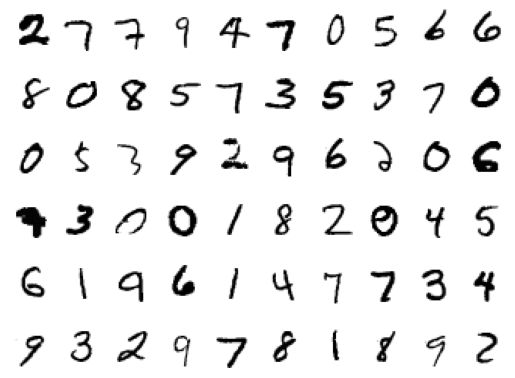

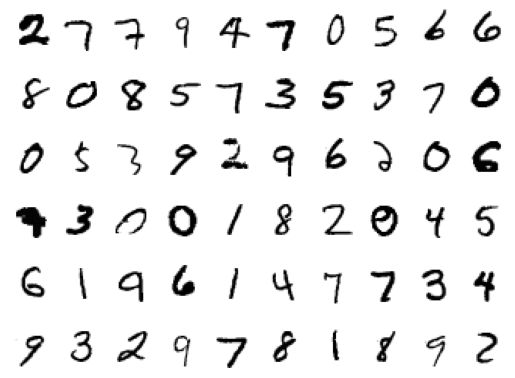

In [10]:
# Define a transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data, applying transformation
trainset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

dataiter = iter(trainloader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
#print(model)

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

#print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
#print('After backward pass: \n', model[0].weight.grad)

In [4]:
def test_optimizer(model, learning_rate, momentum):
    with torch.no_grad():  #Added so gradients aren't kept in tensor
        for param in model.parameters():
            if param.grad is not None:
                if not hasattr(param, 'moment'):
                    param.moment = torch.clone(param.grad).detach()

                param.moment = momentum * param.moment + (1 - momentum) * param.grad
                param.data -= learning_rate * param.moment

time0 = time()
epochs = 300


for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        #Replace optimizer.zero_grad() to clear gradients in parameters
        for param in model.parameters():
            param.grad = None

        output = model(images)  # Forward pass
        loss = criterion(output, labels)  # Compute loss
        loss.backward()  # Backpropagation
        
        #Replaced optimizer with custom optimizer to update weights
        test_optimizer(model, learning_rate=0.001, momentum=0.8)
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 2.225729592319236
Epoch 1 - Training loss: 1.9640165486061243
Epoch 2 - Training loss: 1.526267131254363
Epoch 3 - Training loss: 1.1155574287432852
Epoch 4 - Training loss: 0.848683685254949
Epoch 5 - Training loss: 0.687773453560211
Epoch 6 - Training loss: 0.5895994437147559
Epoch 7 - Training loss: 0.5261865816772111
Epoch 8 - Training loss: 0.4826691296976258
Epoch 9 - Training loss: 0.45108905836526775
Epoch 10 - Training loss: 0.4273226337233332
Epoch 11 - Training loss: 0.40906384258445644
Epoch 12 - Training loss: 0.3941248524894338
Epoch 13 - Training loss: 0.3820221603297984
Epoch 14 - Training loss: 0.3716231835072737
Epoch 15 - Training loss: 0.36281076138779556
Epoch 16 - Training loss: 0.3549719867008581
Epoch 17 - Training loss: 0.3481063881932672
Epoch 18 - Training loss: 0.34180149406607724
Epoch 19 - Training loss: 0.33613206655073014
Epoch 20 - Training loss: 0.33084032485988346
Epoch 21 - Training loss: 0.3258210080248842
Epoch 22 - Trainin

In [5]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9731


In [11]:
####Redo training because I'm dumb and need to save losses for  validation plot
def test_optimizer(model, learning_rate, momentum):
    with torch.no_grad():  #Added so gradients aren't kept in tensor
        for param in model.parameters():
            if param.grad is not None:
                if not hasattr(param, 'moment'):
                    param.moment = torch.clone(param.grad).detach()

                param.moment = momentum * param.moment + (1 - momentum) * param.grad
                param.data -= learning_rate * param.moment

time0 = time()
epochs = 300
epoch_losses = []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        #Replace optimizer.zero_grad() to clear gradients in parameters
        for param in model.parameters():
            param.grad = None

        output = model(images)  # Forward pass
        loss = criterion(output, labels)  # Compute loss
        loss.backward()  # Backpropagation
        
        #Replaced optimizer with custom optimizer to update weights
        test_optimizer(model, learning_rate=0.001, momentum=0.8)
        
        running_loss += loss.item()
    
    else:
        epoch_losses.append(running_loss / len(trainloader))
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.209342061329498
Epoch 1 - Training loss: 1.9300054629474306
Epoch 2 - Training loss: 1.4933932136370938
Epoch 3 - Training loss: 1.104885212838777
Epoch 4 - Training loss: 0.8458328682984879
Epoch 5 - Training loss: 0.6895401771071115
Epoch 6 - Training loss: 0.5927488604651839
Epoch 7 - Training loss: 0.5287034932547795
Epoch 8 - Training loss: 0.4844985524855697
Epoch 9 - Training loss: 0.4525450671405426
Epoch 10 - Training loss: 0.42884826472700277
Epoch 11 - Training loss: 0.4103177614144679
Epoch 12 - Training loss: 0.39556659626236346
Epoch 13 - Training loss: 0.38326097734129505
Epoch 14 - Training loss: 0.3730824195118601
Epoch 15 - Training loss: 0.36435077688904965
Epoch 16 - Training loss: 0.35683748907626056
Epoch 17 - Training loss: 0.34988008677832355
Epoch 18 - Training loss: 0.3438248292151799
Epoch 19 - Training loss: 0.3382660578658332
Epoch 20 - Training loss: 0.3332402056404777
Epoch 21 - Training loss: 0.32845871253753267
Epoch 22 - Trai

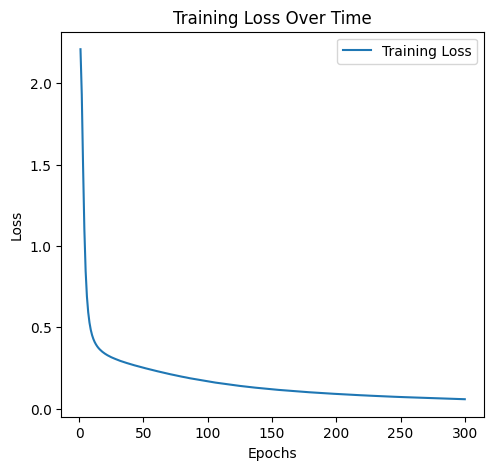

In [13]:
epochs = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()


